In [1]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

In [7]:
DATA_ROOT = "../data/"

In [8]:
def loadSimData():
    # for algorithm test
    dataMat = np.array([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]], dtype='float')
    classLabels = np.array([1.0, 1.0, -1.0, -1.0, 1.0], dtype='float')
    return dataMat, classLabels 

In [9]:
min(dataMat[:,1])

1.0

In [ ]:
dataMat, classLabels = loadSimData()
uniqueClass = np.unique(classLabels)
class1 = uniqueClass[0]
class2 = uniqueClass[1]

plt.figure()
dataClass1 = dataMat[classLabels == class1, :]
print(dataClass1[:,0])
print(np.shape(dataClass1))
plt.scatter(dataClass1[:,0], dataClass1[:,1], c='r', label = 'class1')
dataClass2 = dataMat[classLabels == class2, :]
print(dataClass2)
plt.scatter(dataClass2[:,0], dataClass2[:,1], c='g', label = 'class2')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([min(dataMat[:,0])-0.5, max(dataMat[:,0])+0.5 ])
plt.ylim([min(dataMat[:,1])-0.5, max(dataMat[:,1])+0.5 ])
plt.legend(loc='best')

[ 1.3  1. ]
(2, 2)
[[ 1.   2.1]
 [ 2.   1.1]
 [ 2.   1. ]]


## weak classifier realization: one layer decistion tree (stump)

In [5]:
def stumpClassify(dataArr, dimen, threshVal, threshIneq):
    retPredArr = np.ones((np.shape(dataArr)[0], 1))
    if threshIneq == 'lt':
        retPredArr[dataArr[:,dimen] <= threshVal] = -1
    else:
        retPredArr[dataArr[:,dimen] > threshVal] = -1
    
    return retPredArr

def buildStump(dataArr, labelsArr, weights, numSteps = 10.0):
    m, n = np.shape(dataArr)
    labelsArr = labelsArr.reshape(len(labelsArr), 1)
    print(labelsArr.shape)
    bestStump = {}
    bestClassEst = np.zeros((m, 1))
    minError = np.inf
    for i in range(n): # traverse each feature
        rangeMin = min(dataArr[:,i])
        rangeMax = max(dataArr[:,i])
        stepSize = (rangeMax - rangeMin) / numSteps
        for j in range(-1, np.int(numSteps)+1):
            for inequal in ('lt', 'gt'):
                threshVal = rangeMin + float(j)*stepSize
                predicVal = stumpClassify(dataArr, i, threshVal, inequal)
                errArr = np.ones((m, 1))
                errArr[labelsArr == predicVal] = 0
                errWeighted = np.sum(weights*errArr)
                #print("dim = %d threshold = %.2f, inequal = %s, errWeighted = %.3f" % (i, threshVal, inequal, errWeighted))
                if errWeighted < minError:
                    minError = errWeighted
                    bestClassEst = predicVal
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClassEst

In [102]:
weights = np.ones((5,1))
dataArr, labelsArr = loadSimData()
buildStump(dataArr, labelsArr, weights)

(5, 1)
dim = 0 threshold = 0.90, inequal = lt, errWeighted = 2.000
dim = 0 threshold = 0.90, inequal = gt, errWeighted = 3.000
dim = 0 threshold = 1.00, inequal = lt, errWeighted = 2.000
dim = 0 threshold = 1.00, inequal = gt, errWeighted = 3.000
dim = 0 threshold = 1.10, inequal = lt, errWeighted = 2.000
dim = 0 threshold = 1.10, inequal = gt, errWeighted = 3.000
dim = 0 threshold = 1.20, inequal = lt, errWeighted = 2.000
dim = 0 threshold = 1.20, inequal = gt, errWeighted = 3.000
dim = 0 threshold = 1.30, inequal = lt, errWeighted = 1.000
dim = 0 threshold = 1.30, inequal = gt, errWeighted = 4.000
dim = 0 threshold = 1.40, inequal = lt, errWeighted = 1.000
dim = 0 threshold = 1.40, inequal = gt, errWeighted = 4.000
dim = 0 threshold = 1.50, inequal = lt, errWeighted = 1.000
dim = 0 threshold = 1.50, inequal = gt, errWeighted = 4.000
dim = 0 threshold = 1.60, inequal = lt, errWeighted = 1.000
dim = 0 threshold = 1.60, inequal = gt, errWeighted = 4.000
dim = 0 threshold = 1.70, inequal

({'dim': 0, 'ineq': 'lt', 'thresh': 1.3}, 1.0, array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

## Realization the AdaBoost Algorithm
```
    for each iteration:
        find the best decision stump by 'buildStump()' function  
        add the best decision stump into the whole array of week classifier  
        calculate the 'alpha'  
        update the vector of weights
        update the aggregate class estimated value
        
        if error == 0.0:
            break
```

In [142]:
def adaBoostTrainDS(dataArr, labelsArr, numIter = 40):
    weakClassifierList = []
    labelsArr = labelsArr.reshape(len(labelsArr), 1)
    m = dataArr.shape[0]
    weights = np.ones((m,1))/m  # initial weight is 1/m
    aggClassEst = np.zeros((m,1))
    
    for i in range(numIter):
        bestStump, error, classEst = buildStump(dataArr, labelsArr, weights)
        #print("weights: ", weights.T)
        alpha = float( 0.5 * np.log( (1-error)/max(error, 1e-16) ) ) # max(error, 1e-16) avoid overflow
        bestStump['alpha'] = alpha
        weakClassifierList.append(bestStump)
        #print("classEst", classEst.T)
        
        # labelsArr * classEst = 1 : classify accurately , so exp(-1*alpha)
        # labelsaRR * classEst = -1 : classify error, so exp(alpha)
        expon = (-1*alpha*(labelsArr*classEst.reshape(len(classEst),1)))
        weights = weights * np.exp(expon)
        weights = weights / np.sum(weights)
        
        aggClassEst += alpha * classEst # vote class by weights
        #print("aggClassEst: ", aggClassEst.T)
        aggErrors = (np.sign(aggClassEst) != labelsArr) * np.ones((m, 1))
        
        errorRate = np.sum(aggErrors) / m
        print("total error : ", errorRate)
        
        if errorRate == 0.0 : 
            break
    
    return weakClassifierList, aggClassEst

In [146]:
dataArr, labelsArr = loadSimData()
weakClassifierList,_ = adaBoostTrainDS(dataArr, labelsArr)
print(weakClassifierList)

(5, 1)
('total error : ', 0.20000000000000001)
(5, 1)
('total error : ', 0.20000000000000001)
(5, 1)
('total error : ', 0.0)
[{'dim': 0, 'ineq': 'lt', 'thresh': 1.3, 'alpha': 0.6931471805599453}, {'dim': 1, 'ineq': 'lt', 'thresh': 1.0, 'alpha': 0.9729550745276565}, {'dim': 0, 'ineq': 'lt', 'thresh': 0.90000000000000002, 'alpha': 0.8958797346140273}]


## AdaBoost classify for unseen data

In [147]:
def adaClassify(dataArr, classifierList):
    dataArr = np.mat(dataArr)
    m,n = dataArr.shape
    aggClassEst = np.zeros((m,1))
    for i in range(len(classifierList)):
        classifier = classifierList[i]
        classEst = stumpClassify(dataArr, 
                                 classifier['dim'], 
                                 classifier['thresh'], 
                                 classifier['ineq'])
        aggClassEst += classifier['alpha'] * classEst
        #print(aggClassEst.T)
    
    return np.sign(aggClassEst)

In [148]:
adaClassify([0,0], weakClassifierList)

array([[-1.]])

In [149]:
adaClassify([[0,0], [5,5]], weakClassifierList)

array([[-1.],
       [ 1.]])

## A real case :

In [6]:
def loadDataSet(filename):
    numFeat = len( open(filename).readline().split('\t') )
    dataList = []
    labelsList = []
    fr = open(filename)
    for line in fr.readlines():
        curLineList = line.split('\t')
        attributeList = [ float(x) for x in curLineList[:-2]]
        dataList.append(attributeList)
        # map the original label 
        # 1 -> 1
        # 0 -> -1
        curLabel = float(curLineList[-1])
        if curLabel == 1.0:
            labelsList.append(curLabel)
        else:
            labelsList.append(-1.0)
    return np.array(dataList), np.array(labelsList)

In [151]:
dataArr, labelsArr = loadDataSet(DATA_ROOT + 'horseColicTraining.txt')
print(dataArr[:5, :])
print(labelsArr[:5])
classifierList,_ = adaBoostTrainDS(dataArr, labelsArr)

[[   2.     1.    38.5   66.    28.     3.     3.     0.     2.     5.
     4.     4.     0.     0.     0.     3.     5.    45.     8.4    0. ]
 [   1.     1.    39.2   88.    20.     0.     0.     4.     1.     3.
     4.     2.     0.     0.     0.     4.     2.    50.    85.     2. ]
 [   2.     1.    38.3   40.    24.     1.     1.     3.     1.     3.
     3.     1.     0.     0.     0.     1.     1.    33.     6.7    0. ]
 [   1.     9.    39.1  164.    84.     4.     1.     6.     2.     2.
     4.     4.     1.     2.     5.     3.     0.    48.     7.2    3. ]
 [   2.     1.    37.3  104.    35.     0.     0.     6.     2.     0.
     0.     0.     0.     0.     0.     0.     0.    74.     7.4    0. ]]
[-1. -1.  1. -1. -1.]
(299, 1)
('total error : ', 0.28428093645484948)
(299, 1)
('total error : ', 0.28428093645484948)
(299, 1)
('total error : ', 0.24749163879598662)
(299, 1)
('total error : ', 0.24749163879598662)
(299, 1)
('total error : ', 0.25418060200668896)
(299, 1)
('t

In [152]:
dataTestArr, labelsTestArr = loadDataSet(DATA_ROOT + 'horseColicTest.txt')
print(dataTestArr[:5,:])
print(labelsTestArr[:5])
predClass = adaClassify(dataTestArr, classifierList)
errArr = np.ones((len(predClass), 1))
labelsTestArr = labelsTestArr.reshape(len(labelsTestArr), 1)
errorNum = errArr[predClass != labelsTestArr].sum()
errorRate = errorNum / len(predClass)
print(errorNum)
print(errorRate)

[[  2.    1.   38.5  54.   20.    0.    1.    2.    2.    3.    4.    1.
    2.    2.    5.9   0.    2.   42.    6.3   0. ]
 [  2.    1.   37.6  48.   36.    0.    0.    1.    1.    0.    3.    0.
    0.    0.    0.    0.    0.   44.    6.3   1. ]
 [  1.    1.   37.7  44.   28.    0.    4.    3.    2.    5.    4.    4.
    1.    1.    0.    3.    5.   45.   70.    3. ]
 [  1.    1.   37.   56.   24.    3.    1.    4.    2.    4.    4.    3.
    1.    1.    0.    0.    0.   35.   61.    3. ]
 [  2.    1.   38.   42.   12.    3.    0.    3.    1.    1.    0.    1.
    0.    0.    0.    0.    2.   37.    5.8   0. ]]
[ 1.  1.  1. -1.  1.]
13.0
0.194029850746


## non-uniform dataset & ROC 

In [214]:
def plotROC(predStrengthsArr, classLabelsArr):
    predStrengthsArr = np.array(predStrengthsArr)
    classLabelsArr = np.array(classLabelsArr)
   
    numPositive = sum(classLabelsArr == 1)
    numNegative = len(classLabelsArr) - numPositive
    yStepSize = 1.0 / float(numPositive)
    xStepSize = 1.0 / float(numNegative)
    
    print("numPositive : %d, numNegative: %d, yStepSize = %.2f, xStepSize = %.2f"
          % (numPositive, numNegative, yStepSize, xStepSize))
    
    sortedIndexs = predStrengthsArr.argsort()
    
    cur = (1.0, 1.0)  # start point to plot, all of elements are marked as positive 
    ySum = 0.0 # for AUC calculation
    plt.figure()
    plt.clf()
    
    for i in sortedIndexs: # iteration to add negative element
        # [0...i] negative
        # [i+1, .. end] positive
        if classLabelsArr[i] == 1.0: 
            # error, positive instance is classified as negative
            # which will lead the TPR decrease
            delx = 0
            dely = yStepSize
        else: 
            # correct, negative instance is classified as positive
            # which will lead the FPR decrease
            delx = xStepSize
            dely = 0
            ySum += cur[1]
        
        plt.plot([cur[0], cur[0] - delx], [cur[1], cur[1] - dely], c='b') # line segment
        cur = (cur[0]-delx, cur[1]-dely)
    
    plt.plot([0,1], [0,1], 'b--') # baseline
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True positive Rate (TPR)")
    plt.title("ROC")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()
    # for calculation of AUC:
    # for each iteration appove we got a small rectangle with hight yi = cur[1] and wid xStepSize
    # so the Area = [y0*xStepSize + y1*xStepSize + ... + yn*xStepSize] = [y0+y1+...+yn]*xStepSize = ySum*xStepSize
    print("The Area Under the Curve (AUC) is :", ySum*xStepSize)

In [153]:
dataArr, labelsArr = loadDataSet(DATA_ROOT + 'horseColicTraining.txt')
print(dataArr[:5, :])
print(labelsArr[:5])
classifierList, aggClassEst= adaBoostTrainDS(dataArr, labelsArr)

[[   2.     1.    38.5   66.    28.     3.     3.     0.     2.     5.
     4.     4.     0.     0.     0.     3.     5.    45.     8.4    0. ]
 [   1.     1.    39.2   88.    20.     0.     0.     4.     1.     3.
     4.     2.     0.     0.     0.     4.     2.    50.    85.     2. ]
 [   2.     1.    38.3   40.    24.     1.     1.     3.     1.     3.
     3.     1.     0.     0.     0.     1.     1.    33.     6.7    0. ]
 [   1.     9.    39.1  164.    84.     4.     1.     6.     2.     2.
     4.     4.     1.     2.     5.     3.     0.    48.     7.2    3. ]
 [   2.     1.    37.3  104.    35.     0.     0.     6.     2.     0.
     0.     0.     0.     0.     0.     0.     0.    74.     7.4    0. ]]
[-1. -1.  1. -1. -1.]
(299, 1)
('total error : ', 0.28428093645484948)
(299, 1)
('total error : ', 0.28428093645484948)
(299, 1)
('total error : ', 0.24749163879598662)
(299, 1)
('total error : ', 0.24749163879598662)
(299, 1)
('total error : ', 0.25418060200668896)
(299, 1)
('t

numPositive : 178, numNegative: 121, yStepSize = 0.01, xStepSize = 0.01


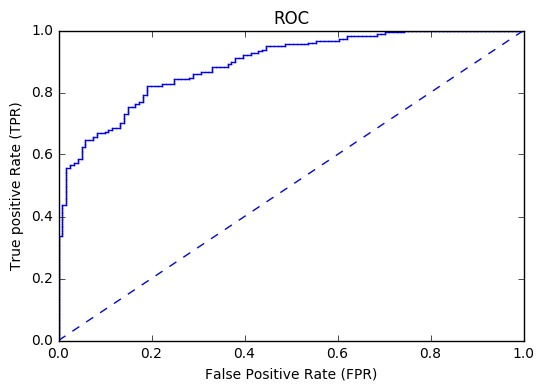

('The Area Under the Curve (AUC) is :', 0.8918191104095093)


In [215]:
plotROC(aggClassEst[:,0], labelsArr)